In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
from lib import *
#load the data
data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/arrhythmia/arrhythmia.data', header=None, sep=',', engine='python')

display(data.head(3))

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,279
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,10


In [2]:
print('%d rows and %d columns' % (data.shape[0],data.shape[1]))

452 rows and 280 columns


In [3]:
np.unique(data[len(data.columns)-1])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 14, 15, 16], dtype=int64)

In [4]:
data['arrhythmia'] = data[len(data.columns)-1].map(lambda x: 0 if x==1 else 1)

In [5]:
data.groupby(['arrhythmia']).size()

arrhythmia
0    245
1    207
dtype: int64

In [6]:
data = data._get_numeric_data()
print('%d rows and %d columns' % (data.shape[0],data.shape[1]))

452 rows and 276 columns


In [7]:
data.head(3)

,0,1,2,3,4,5,6,7,8,9,...,271,272,273,274,275,276,277,278,279,arrhythmia
0,75,0,190,80,91,193,371,174,121,-16,...,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8,1
1,56,1,165,64,81,174,401,149,39,25,...,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6,1
2,54,0,172,95,138,163,386,185,102,96,...,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,10,1


In [8]:
X = data.iloc[:, :-2]  # The first to third-last columns are the features
y = data.iloc[:, -1]   # The last column is the ground-truth label
print(np.unique(y))

[0 1]


In [9]:
# splitting the dataset to training and validation datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20171012)

In [10]:
# Standardizing the training and test datasets
# Note that we are scaling based on the information from the training data
# Then we apply the scaling that is done from training data to the test data

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [11]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=1000.0, random_state=0)
lr.fit(X_train_std, y_train)

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
print(X_combined_std.shape)
print(y_combined.shape)

(452, 274)
(452,)


In [12]:
from sklearn.metrics import roc_curve
probas = lr.predict_proba(X_test_std)

fpr, tpr, thresholds = roc_curve(y_test,
                                 probas[:, 0],
                                 pos_label=0)

In [13]:
from sklearn.metrics import auc

print('AUC: %.2f' % auc(fpr, tpr))

AUC: 0.70


-2.0


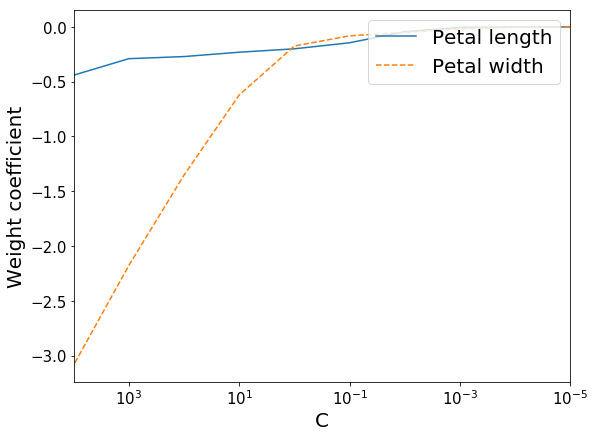

In [14]:
weights, params = [], []
over_c = []
for c in np.arange(-5, 5, dtype='float32'):
    lr = LogisticRegression(C=10**c, random_state=0)
    lr.fit(X_train_std, y_train)
    probas = lr.predict_proba(X_test_std)

    fpr, tpr, thresholds = roc_curve(y_test,
                                 probas[:, 0],
                                 pos_label=0)
    if auc(fpr, tpr) >= 0.79:
        over_c.append(c)
        print (c)
    # get the coefficients of w
    weights.append(lr.coef_[0])
    params.append(10**c)
fig, ax = plt.subplots(figsize=(8,6))
weights = np.array(weights)
plt.plot(params, weights[:, 0],
         label='Petal length')
plt.plot(params, weights[:, 1],
         label='Petal width', linestyle='--')
plt.xlim(10**4, 10**-5)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Weight coefficient')
plt.legend(loc='upper right')
plt.tight_layout()
plt.legend(loc=1, prop={'size': 20})
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.savefig('./output/fig-logistic-regression-c.png', dpi=300)
plt.show()

In [15]:
lr = LogisticRegression(C=10**over_c[0], random_state=0)
lr.fit(X_train_std, y_train)
probas = lr.predict_proba(X_test_std)

fpr, tpr, thresholds = roc_curve(y_test,
                             probas[:, 0],
                             pos_label=0)
print('AUC: %.2f' % auc(fpr, tpr))

AUC: 0.80


In [16]:
from sklearn.metrics import confusion_matrix

y_pred = lr.predict(X_test_std)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(4,4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.savefig('./output/fig-logistic-regression-confusion-2.png', dpi=300)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
# plt.show()

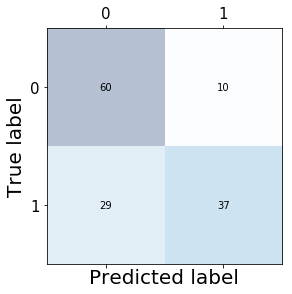

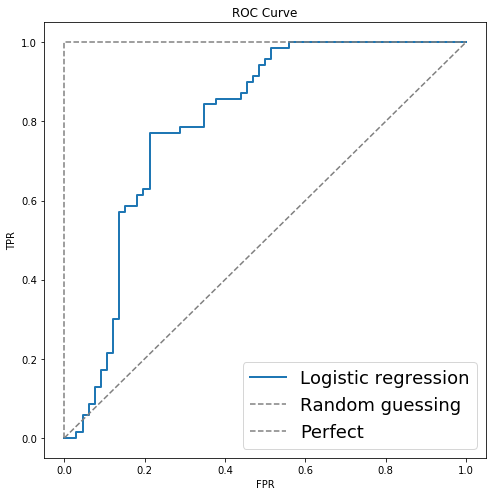

In [17]:
fig = plt.subplots(figsize=(7,7))
plt.plot(fpr, tpr, lw=2,
         label='Logistic regression')
    
plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color='gray',
         label='Random guessing')

plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle='--',
         color='gray',
         label='Perfect')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.legend(loc=4, prop={'size': 18})
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.savefig('./output/fig-roc-lg.png', dpi=300)
plt.show()

# It is worse than random guessing at first, but it soon grows fast about 10% FPR.
# true positive : 60 true neagetive : 37 total : 136
# so Accuracy is 97/136 = 0.71